In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import openai

# 设置OpenAI API密钥
openai.api_key = 'YOUR_OPENAI_API_KEY'

# 1. 数据收集与预处理
# 加载比特币价格数据
price_data_url = 'https://raw.githubusercontent.com/STATS201-DKU-Autumn2024/Problem_Set_1.Peilin_Wu/refs/heads/main/Data/bitcoin0.csv'
price_df = pd.read_csv(price_data_url)

# 转换时间戳为日期格式
price_df['time'] = pd.to_datetime(price_df['time'], unit='ms')
price_df.set_index('time', inplace=True)

# 选择需要的列
price_df = price_df[['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]

# 加载市场情绪数据
sentiment_data_url = 'https://raw.githubusercontent.com/STATS201-DKU-Autumn2024/Problem_Set_1.Peilin_Wu/refs/heads/main/Data/google%20trends/geoMapbitcoin.csv'
sentiment_df = pd.read_csv(sentiment_data_url)

# 数据清洗与合并
# 假设情绪数据包含日期列 'date'，需要与价格数据的日期对齐
# 这里需要根据实际的情绪数据格式进行处理
# sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
# sentiment_df.set_index('date', inplace=True)

# 合并数据集
# combined_df = price_df.join(sentiment_df, how='inner')

# 由于情绪数据格式未知，这里仅使用价格数据进行示例
combined_df = price_df.copy()

# 归一化处理
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_df)

# 2. 噪声处理（扩散模型）
# 定义扩散模型
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 初始化模型
input_dim = scaled_data.shape[1]
diffusion_model = DiffusionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(diffusion_model.parameters(), lr=0.001)

# 准备数据
X = torch.tensor(scaled_data[:-1], dtype=torch.float32)
y = torch.tensor(scaled_data[1:], dtype=torch.float32)

# 训练扩散模型
epochs = 100
for epoch in range(epochs):
    diffusion_model.train()
    optimizer.zero_grad()
    outputs = diffusion_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 去噪处理
diffusion_model.eval()
with torch.no_grad():
    denoised_data = diffusion_model(X).numpy()

# 3. 时间序列预测（LSTM）
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# 设置参数
input_size = input_dim
hidden_size = 50
num_layers = 2
output_size = input_dim
sequence_length = 30

# 准备LSTM输入数据
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_lstm, y_lstm = create_sequences(denoised_data, sequence_length)
X_lstm = torch.tensor(X_lstm, dtype=torch.float32)
y_lstm = torch.tensor(y_lstm, dtype=torch.float32)

# 初始化LSTM模型
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# 训练LSTM模型
epochs = 50
for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    outputs = lstm_model(X_lstm)
    loss = criterion(outputs, y_lstm)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

lstm_model.eval()
with torch.no_grad():
    # 使用最后的 sequence_length 数据进行预测
    last_sequence = X_lstm[-1].unsqueeze(0)  # Add batch dimension
    predictions = lstm_model(last_sequence).numpy()

# 打印预测值
print("Predicted values (scaled):", predictions)

# 将预测值逆归一化为实际价格
denormalized_predictions = scaler.inverse_transform(predictions)
print("Predicted values (denormalized):", denormalized_predictions)

# 生成投资建议
latest_close_price = scaler.inverse_transform([scaled_data[-1]])[0][0]
predicted_close_price = denormalized_predictions[0][0]

print(f"Latest Close Price: {latest_close_price:.2f}")
print(f"Predicted Close Price: {predicted_close_price:.2f}")

if predicted_close_price > latest_close_price * 1.02:  # 超过当前价格2%时建议买入
    print("Investment Advice: Buy (Price is expected to rise significantly)")
elif predicted_close_price < latest_close_price * 0.98:  # 低于当前价格2%时建议卖出
    print("Investment Advice: Sell (Price is expected to fall significantly)")
else:
    print("Investment Advice: Hold (Price movement is within normal range)")

Epoch [10/100], Loss: 0.0943
Epoch [20/100], Loss: 0.0332
Epoch [30/100], Loss: 0.0218
Epoch [40/100], Loss: 0.0127
Epoch [50/100], Loss: 0.0062
Epoch [60/100], Loss: 0.0035
Epoch [70/100], Loss: 0.0025
Epoch [80/100], Loss: 0.0022
Epoch [90/100], Loss: 0.0019
Epoch [100/100], Loss: 0.0018
Epoch [10/50], Loss: 0.0973
Epoch [20/50], Loss: 0.0393
Epoch [30/50], Loss: 0.0225
Epoch [40/50], Loss: 0.0102
Epoch [50/50], Loss: 0.0058
Predicted values (scaled): [[0.87498045 0.96900624 0.9426797  0.9979529  0.07603332 0.19437096]]
Predicted values (denormalized): [[7.1756383e+04 7.8113469e+04 7.3001242e+04 7.6549758e+04 1.0681403e+05
  5.9098025e+09]]
Latest Close Price: 79754.55
Predicted Close Price: 71756.38
Investment Advice: Sell (Price is expected to fall significantly)


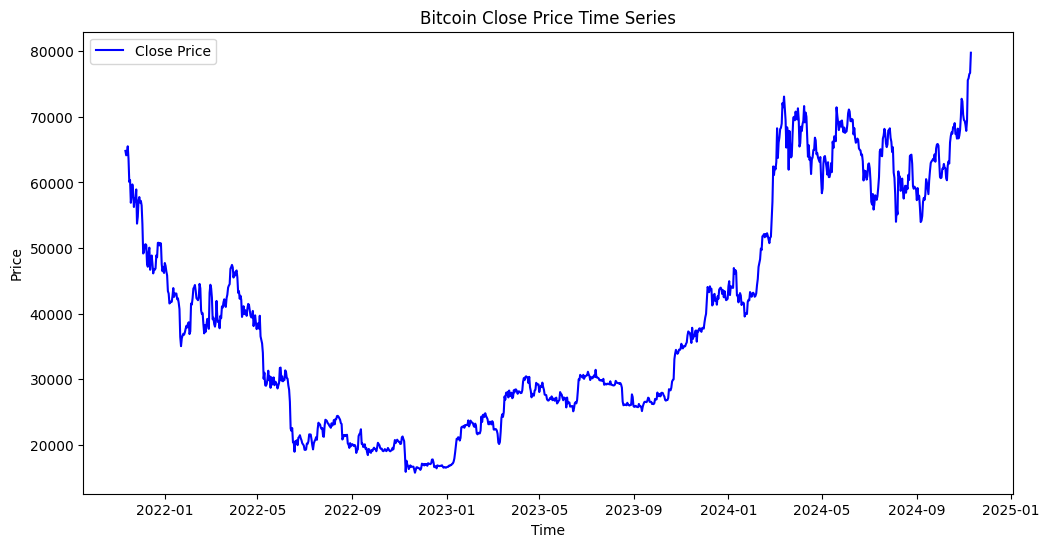

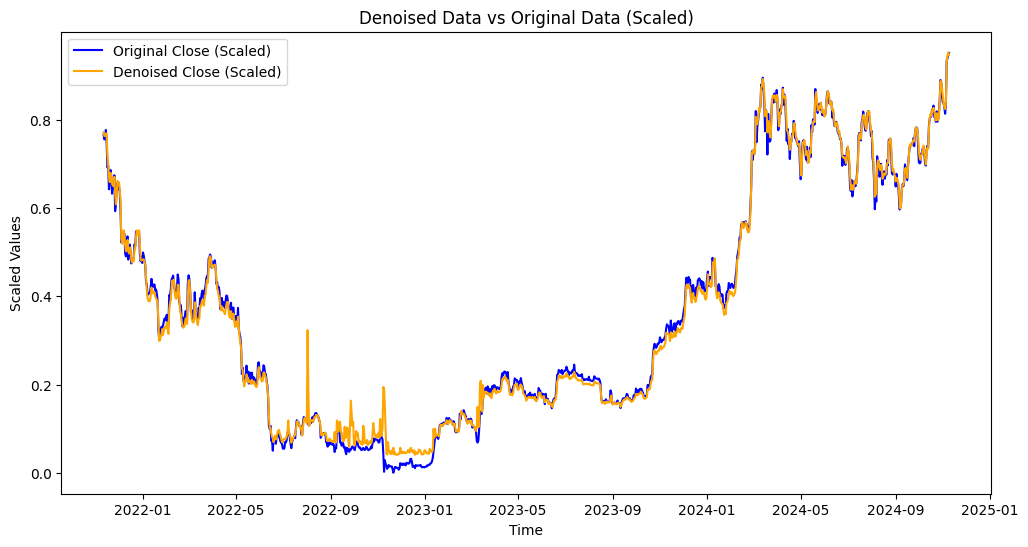

<Figure size 1200x600 with 0 Axes>

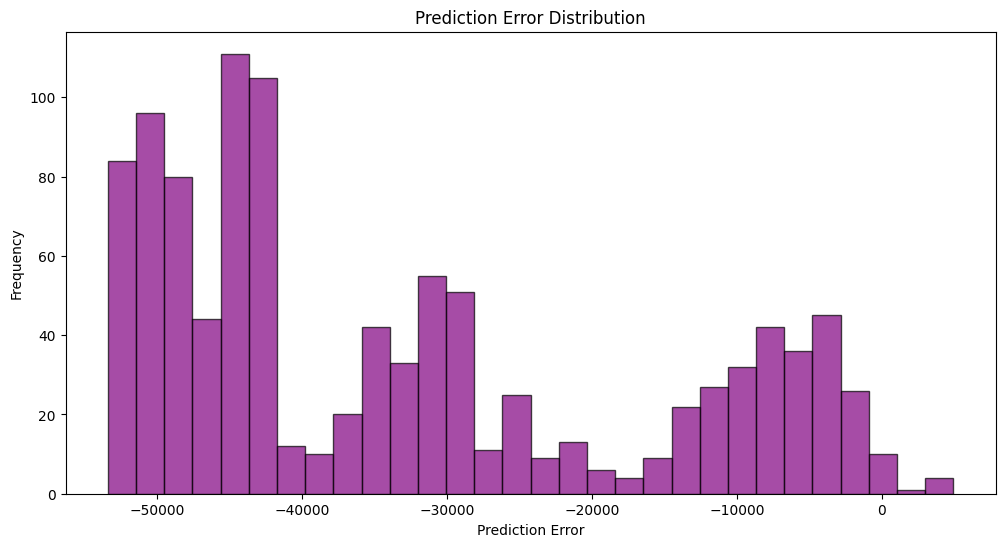

In [12]:
# 逆归一化预测值
denormalized_predictions = scaler.inverse_transform(predictions)

# 图表分析
# 1. 原始数据时间序列图
plt.figure(figsize=(12, 6))
plt.plot(price_df.index, price_df['close'], label='Close Price', color='blue')
plt.title('Bitcoin Close Price Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# 2. 去噪数据 vs 原始数据
plot_length = min(len(price_df), len(denoised_data))  # 取最小长度
plt.figure(figsize=(12, 6))
plt.plot(price_df.index[:plot_length], scaled_data[:plot_length, 0], label='Original Close (Scaled)', color='blue')
plt.plot(price_df.index[:plot_length], denoised_data[:plot_length, 0], label='Denoised Close (Scaled)', color='orange')
plt.title('Denoised Data vs Original Data (Scaled)')
plt.xlabel('Time')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))



# 4. 预测误差分布
errors = scaler.inverse_transform(y_lstm.numpy())[:, 0] - scaler.inverse_transform(predictions)[:, 0]
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()